In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime

In [2]:
OptInfo = {}
OptInfo['Bounds Longitude']     = [230,360]
OptInfo['Bounds Latitude']      = [-80,-40]
OptInfo['Grid Spacing (dx,dy)'] = [5,2.5]
OptInfo['Start Time']           = '2017-05-01'
OptInfo['End Time']             = '2017-06-01'
OptInfo['WayPoints']            = pd.read_csv('../../resources/WayPoints_TestExample.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'
OptInfo['Start Waypoints']      = None

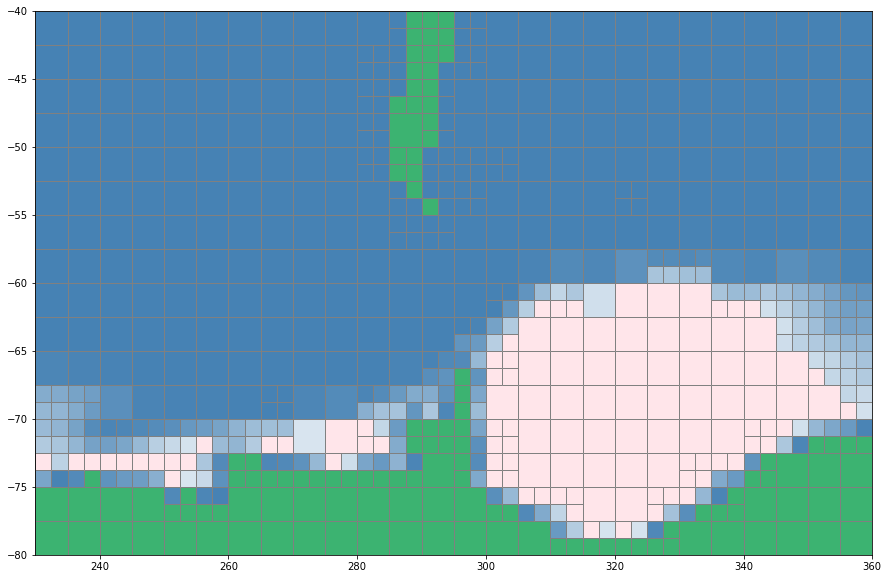

In [3]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(OptInfo)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(1)
cellGrid.plot()

In [4]:
TT = TravelTime(cellGrid)
TT.Dijkstra(verbrose=True)

=== Processing Waypoint = ArgentineSea ===
=== Processing Waypoint = MargueriteBay ===
=== Processing Waypoint = WP3 ===


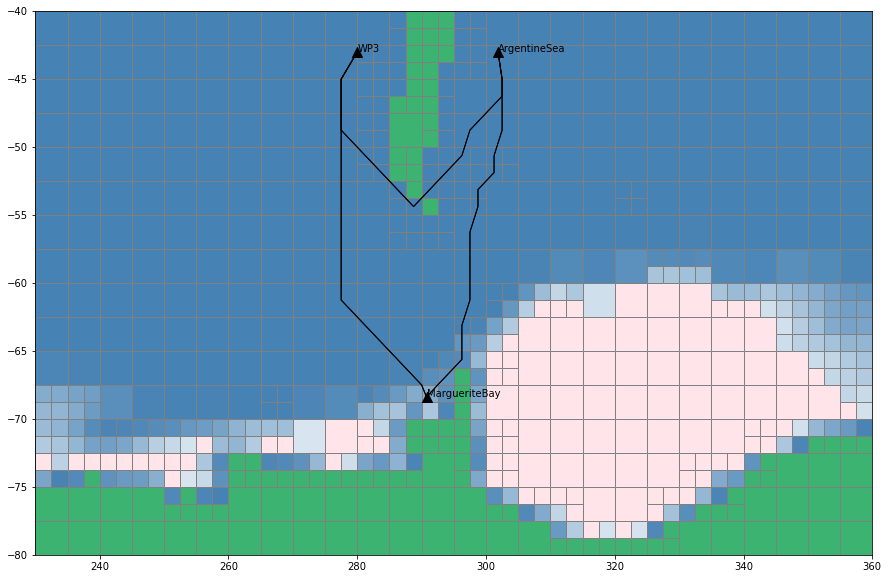

In [5]:
ax = TT.PlotPaths()

In [6]:
TT.PathSmoothing(maxiter=50)

 PATH: ArgentineSea -> MargueriteBay 
 PATH: ArgentineSea -> WP3 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 


/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-pyRoutePlanner/RoutePlanner/Function.py:673: RuntimeWarning: divide by zero encountered in double_scalars
  Y_line = ((Yc-Ys)/(Xc-Xs))*(Xe-Xs) + Ys


Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[279.9999995777149,-47.5];Cp=[280.0,-45.000000000181956];Np=[279.9995213897797,-45.0]
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 


/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-pyRoutePlanner/RoutePlanner/Function.py:26: RuntimeWarning: invalid value encountered in double_scalars
  Px = ((X1*Y2 - Y1*X2)*(X3-X4) - (X1-X2)*(X3*Y4-Y3*X4))/D
/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-pyRoutePlanner/RoutePlanner/Function.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  Py = ((X1*Y2-Y1*X2)*(Y3-Y4)-(Y1-Y2)*(X3*Y4-Y3*X4))/D


Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
No-Case: df_X=0.0,df_Y=0.0; BoxW=1.25; BoxHeight=0.625; Sp=[284.0803175261415,-51.25];Cp=[282.5,-50.07103088690658];Np=[282.50452807293317,-50.0]
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
No-Case: df_X=0.0,df_Y=0.0; BoxW=1.25; BoxHeight=0.625; Sp=[284.03314073120544,-51.25];Cp=[282.5,-50.07103088690658];Np=[283.75,-50.0]
No-Case: df_X=0.0,df_Y=0.0; BoxW=1.25; BoxHeight=0.625; Sp=[282.5,-49.375];Cp=[280.00064620184213,-47.50000202843786];Np=[279.9999798132372,-47.5]
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrect! 
Issue - Box Incorrec

/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-pyRoutePlanner/RoutePlanner/Function.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  Px = ((X1*Y2 - Y1*X2)*(X3-X4) - (X1-X2)*(X3*Y4-Y3*X4))/D
/Users/jsmith/Documents/Research/Researcher_BAS/RoutePlanning/SDADT-pyRoutePlanner/RoutePlanner/Function.py:27: RuntimeWarning: invalid value encountered in double_scalars
  Py = ((X1*Y2-Y1*X2)*(Y3-Y4)-(Y1-Y2)*(X3*Y4-Y3*X4))/D


No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[280.00201294608485,-60.0];Cp=[280.0,-60.002232003152];Np=[282.8312861597586,-62.5]
No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[280.00201294608485,-60.0];Cp=[280.0,-60.002232003152];Np=[282.91224709125436,-62.5]
No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[280.00201294608485,-60.0];Cp=[280.0,-60.002232003152];Np=[282.85373533871456,-62.5]
No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[280.00201294608485,-60.0];Cp=[280.0,-60.002232003152];Np=[282.9143337736531,-62.5]
No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[280.00201294608485,-60.0];Cp=[280.0,-60.002232003152];Np=[282.8672475027983,-62.5]
No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[280.00201294608485,-60.0];Cp=[280.0,-60.002232003152];Np=[282.91549923111165,-62.5]
No-Case: df_X=0.0,df_Y=0.0; BoxW=2.5; BoxHeight=1.25; Sp=[280.00201294608485,-60.0];Cp=[280.0,-60.002232003152];Np=[282.87801393332825,-62.5]
No-Case: 

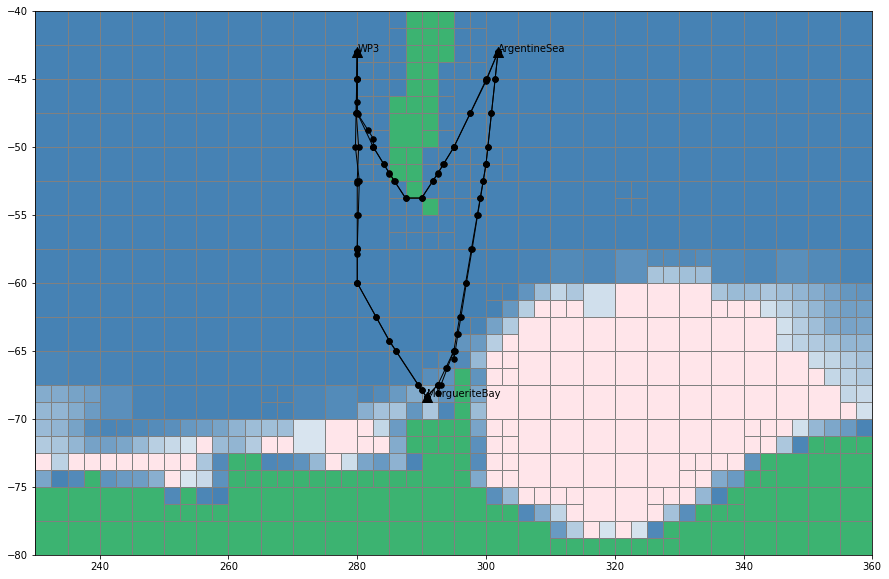

In [7]:
ax = TT.PlotPaths(routepoints=True)

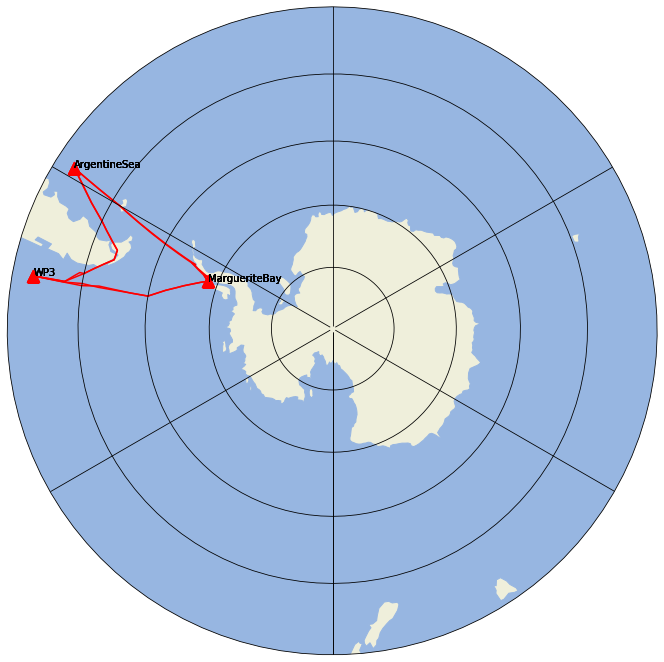

In [9]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature

PATH1 =  TT.Paths[0]['Path']['FullPath']

fig = plt.figure(figsize=[10, 10])
ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)
# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.OCEAN)
ax1.gridlines(color='k')


for ii in range(len(TT.Paths)):
    PATH1 =  TT.Paths[ii]['Path']['FullPath']

    ax1.plot(PATH1[:,0]-360,PATH1[:,1],'r',transform=ccrs.PlateCarree())
    for ii, wpt in OptInfo['WayPoints'].iterrows():
        ax1.scatter(wpt['Long']-360,wpt['Lat'],150,marker='^',color='r',transform=ccrs.PlateCarree())
        ax1.text(wpt['Long']-360,wpt['Lat'],wpt['Name'],transform=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
